In [22]:
# Import Libaries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score

import scipy.cluster.hierarchy as sch

# Import data and stats

The data set consists of two files:
- product discount offers made over the course of a year (32 offers)
- customer purchases (transaction and the offer number associated with it) (324 transactions)

The goal is to use customer segmentation (clustering) to group customers to specific types of discount offers that they would be most attracted to.

In [14]:
# Import Data
offers = pd.read_csv('offers.csv')
transactions = pd.read_csv('transactions.csv')

In [15]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Campaign           32 non-null     object
 1   Varietal           32 non-null     object
 2   Minimum Qty (ltr)  32 non-null     int64 
 3   Discount (%)       32 non-null     int64 
 4   Origin             32 non-null     object
 5   Past Peak          32 non-null     bool  
dtypes: bool(1), int64(2), object(3)
memory usage: 1.4+ KB


In [16]:
offers.describe()

,Minimum Qty (ltr),Discount (%)
count,32.000000,32.000000
mean,65.812500,57.843750
std,50.785722,20.770807
min,6.000000,17.000000
25%,12.000000,44.750000
50%,72.000000,55.000000
75%,72.000000,82.250000
max,144.000000,89.000000


In [17]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer Last Name  324 non-null    object
 1   Offer #             324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [18]:
transactions.describe()

,Offer #
count,324.000000
mean,17.012346
std,9.703332
min,1.000000
25%,8.000000
50%,18.000000
75%,26.000000
max,32.000000


In [19]:
offers['Offer #'] = offers.index + 1
offers.head()

,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,Offer #
0,January,Malbec,72,56,France,False,1
1,January,Pinot Noir,72,17,France,False,2
2,February,Espumante,144,32,Oregon,True,3
3,February,Champagne,72,48,France,True,4
4,February,Cabernet Sauvignon,144,44,New Zealand,True,5


In [20]:
transactions.head()

,Customer Last Name,Offer #
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


In [21]:
# Pivot the transactions file to show a matrix with customer names in the row index and offer numbers as column headers across the top.
# Fill nan's with zeros.

df_pivot = pd.pivot_table(transactions, values = 'Offer #', index = 'Offer #', 
                          columns = ['Customer Last Name'], aggfunc = len)
df_pivot_tp = df_pivot.transpose()
df_pivot_tp.fillna(0, inplace=True)
df_pivot_tp.head(10)

Offer #,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Customer Last Name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Barnes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Bell,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bennett,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Brooks,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


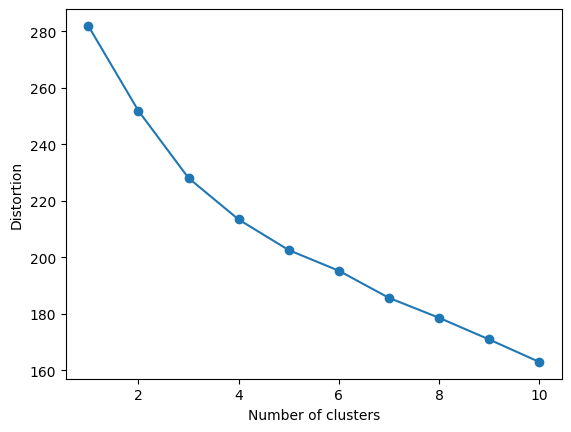

In [57]:
# Generate plot to show where the "elbow" lies in terms of the number of clusters generated.

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df_pivot_tp)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

It seems there is a faint elbow at cluster=3. However, since this plot doesn't give us a definitive answer, we will take a look at the silhouette scores for each of the clusters.

/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

For n_clusters = 2 The average silhouette_score is : 0.09213519139592626
For n_clusters = 3 The average silhouette_score is : 0.12192347136250975
For n_clusters = 4 The average silhouette_score is : 0.1329855630734113
For n_clusters = 5 The average silhouette_score is : 0.14156103218897628


/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.12683737122624272
For n_clusters = 7 The average silhouette_score is : 0.11506693728220245
For n_clusters = 8 The average silhouette_score is : 0.10976482925092354


/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


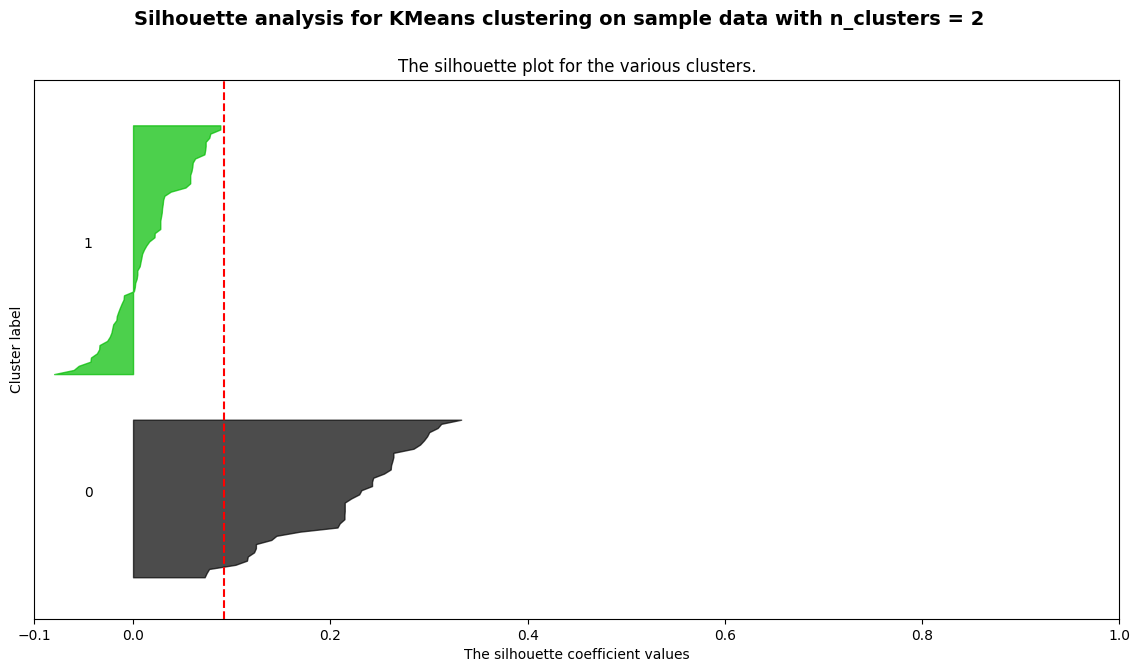

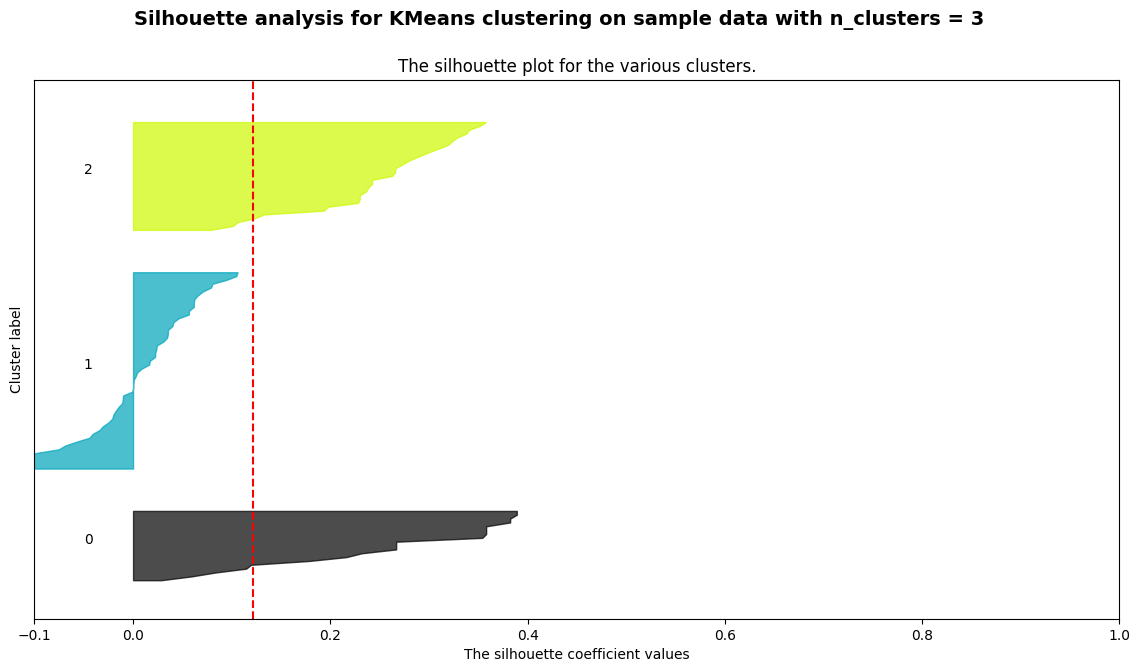

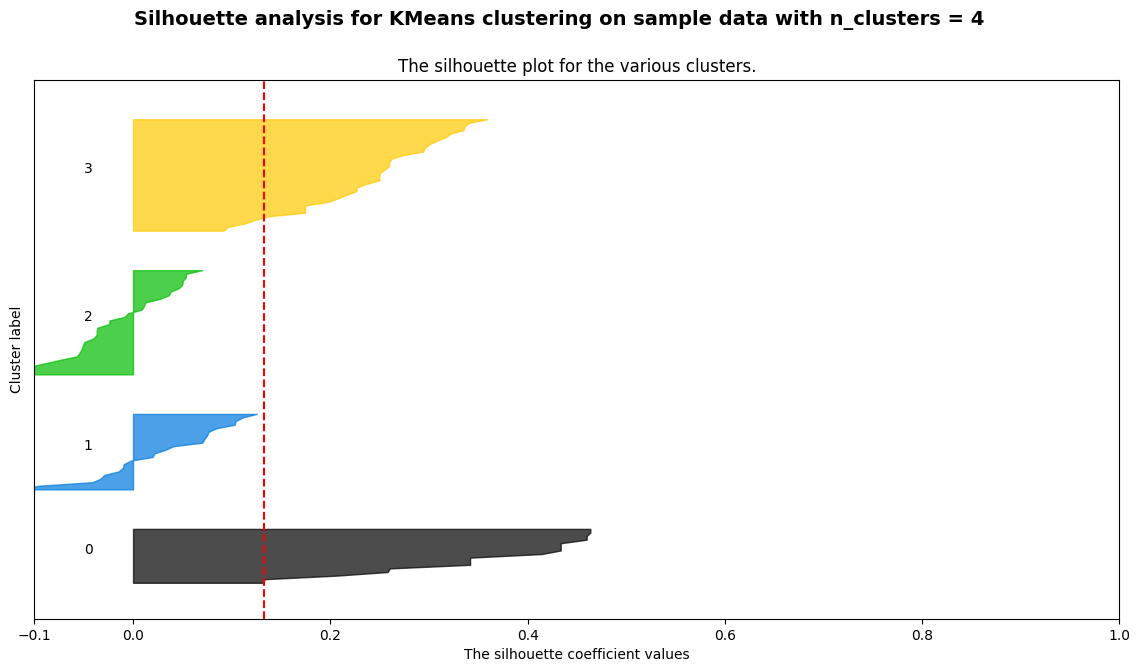

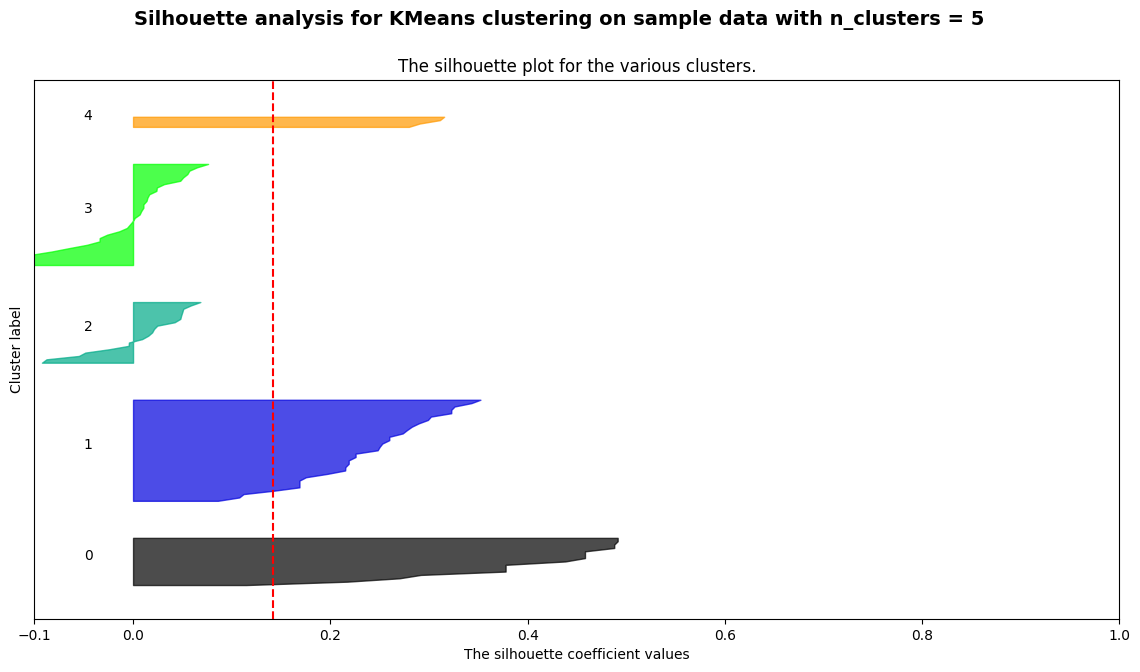

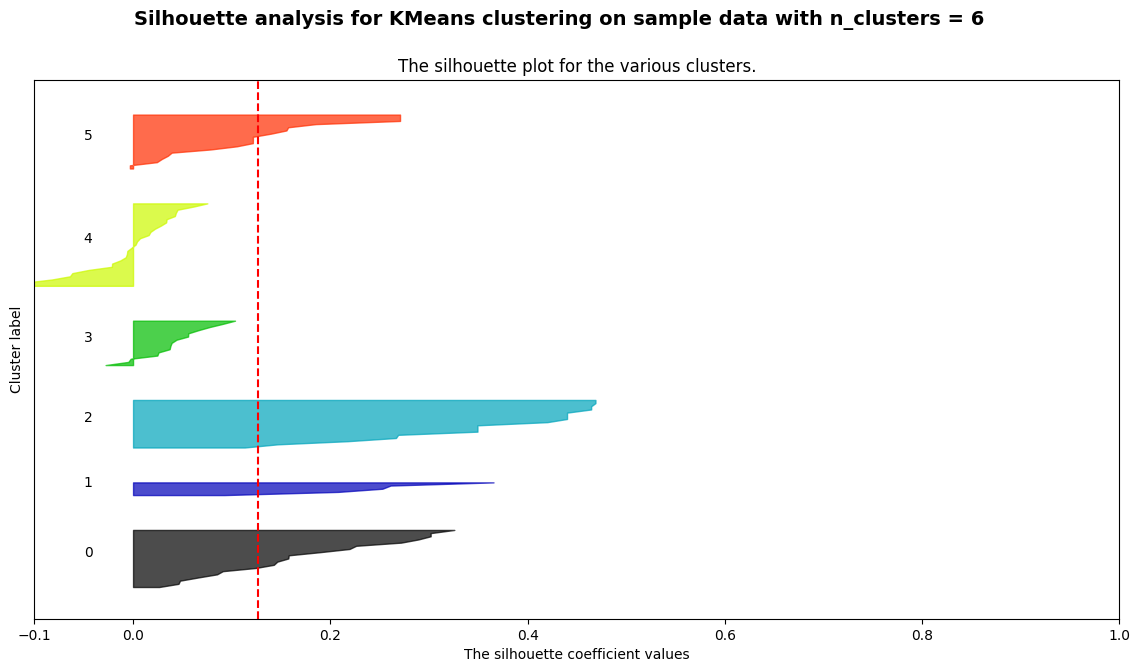

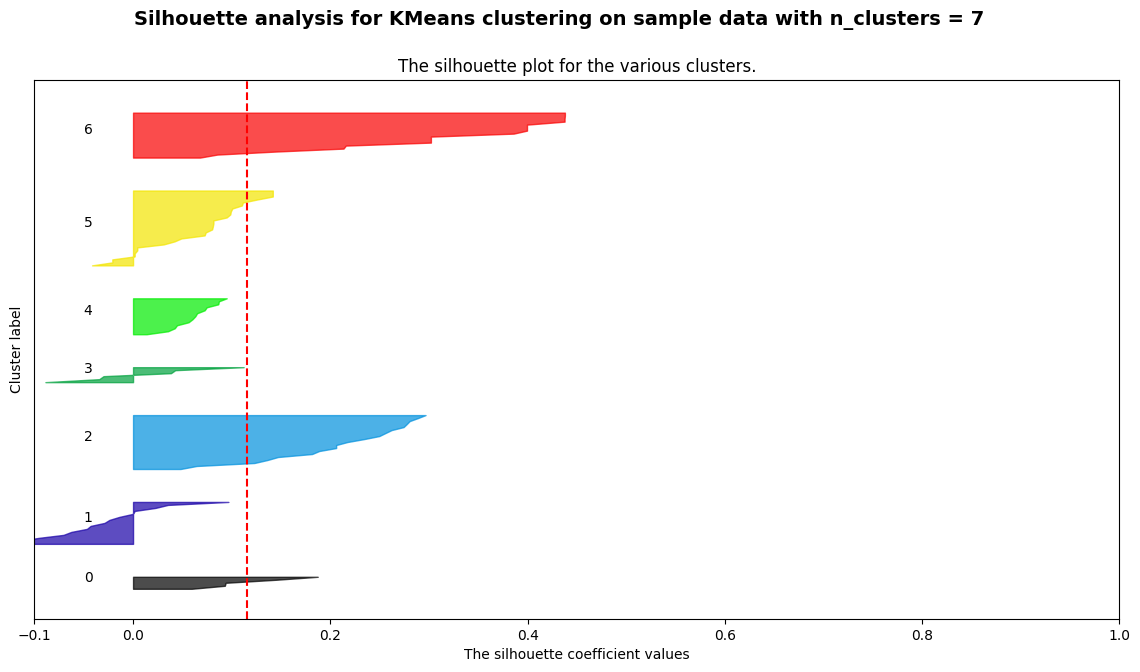

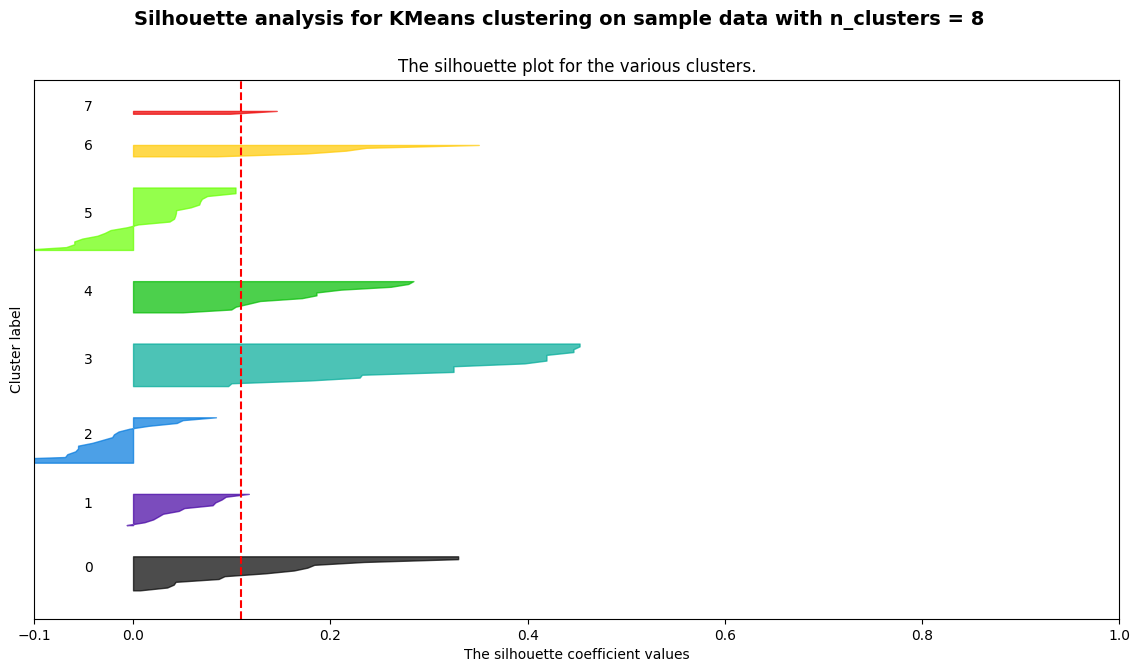

In [59]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots()
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pivot_tp) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_pivot_tp)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_pivot_tp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pivot_tp, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show();

It looks like eight clusters is where we get the highest Silhouette score.

In [60]:
# Set the number of clusters at 5 and run the KMeans algorithm.

kmclusters = 5

kmeans = KMeans(n_clusters=kmclusters, random_state=0).fit(df_pivot_tp)

/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [61]:
# Generate a list customers with cluster assignments.

df_cluster_map = pd.DataFrame()
df_cluster_map['Customer Last Name'] = df_pivot_tp.index.values
df_cluster_map['cluster'] = kmeans.labels_
df_cluster_map.head(15)

,Customer Last Name,cluster
0,Adams,0
1,Allen,2
2,Anderson,1
3,Bailey,0
4,Baker,2
5,Barnes,3
6,Bell,1
7,Bennett,2
8,Brooks,2
9,Brown,0


In [62]:
# Add the transaction matrix to the cluster assignments so they can be summed up for each cluster.

df_cluster_map = df_cluster_map.merge(df_pivot_tp, on = 'Customer Last Name', how = 'right')
df_cluster_map.head(25)

,Customer Last Name,cluster,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,Barnes,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,Bell,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Bennett,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,Brooks,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Brown,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [63]:
# Get rid of the customer names since they are not needed for the counts.

df_cluster_map = df_cluster_map.iloc[:,1:34]
df_cluster_map.head()

,cluster,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [64]:
# Group the matrix table by cluster number and sum up the transactions for each cluster column-wise.

df_cluster_counts = df_cluster_map.groupby('cluster').sum()
df_cluster_counts.head()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.0,16.0,0.0,0.0
1,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,12.0,0.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2.0,4.0,4.0,2.0,4.0,6.0,11.0,6.0,3.0,...,2.0,0.0,4.0,0.0,4.0,4.0,4.0,2.0,9.0,3.0
3,8.0,2.0,0.0,4.0,2.0,3.0,0.0,0.0,4.0,3.0,...,2.0,0.0,2.0,3.0,0.0,2.0,0.0,4.0,7.0,1.0
4,0.0,0.0,2.0,4.0,0.0,5.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0


In [65]:
# Transpose the cluster counts so we can add the offer details back into the matrix.

df_cluster_counts_tp = df_cluster_counts.transpose()
df_cluster_counts_tp.index.name = "Offer #"
df_cluster_counts_tp.head(33)

cluster,0,1,2,3,4
Offer #,,,,,
1,0.0,1.0,1.0,8.0,0.0
2,0.0,6.0,2.0,2.0,0.0
3,0.0,0.0,4.0,0.0,2.0
4,0.0,0.0,4.0,4.0,4.0
5,0.0,0.0,2.0,2.0,0.0
6,0.0,0.0,4.0,3.0,5.0
7,12.0,0.0,6.0,0.0,1.0
8,9.0,0.0,11.0,0.0,0.0
9,0.0,0.0,6.0,4.0,0.0


In [68]:
# Add the offer details back into the cluster transaction count matrix so we can start sorting by cluster to find insights.

df_offer_clusters = offers.merge(df_cluster_counts_tp, on='Offer #', how='right')
df_offer_clusters = df_offer_clusters[['Offer #'] + [ col for col in df_offer_clusters.columns if col != 'Offer #' ]]
df_offer_clusters

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3,4
0,1,January,Malbec,72,56,France,False,0.0,1.0,1.0,8.0,0.0
1,2,January,Pinot Noir,72,17,France,False,0.0,6.0,2.0,2.0,0.0
2,3,February,Espumante,144,32,Oregon,True,0.0,0.0,4.0,0.0,2.0
3,4,February,Champagne,72,48,France,True,0.0,0.0,4.0,4.0,4.0
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True,0.0,0.0,2.0,2.0,0.0
5,6,March,Prosecco,144,86,Chile,False,0.0,0.0,4.0,3.0,5.0
6,7,March,Prosecco,6,40,Australia,True,12.0,0.0,6.0,0.0,1.0
7,8,March,Espumante,6,45,South Africa,False,9.0,0.0,11.0,0.0,0.0
8,9,April,Chardonnay,144,57,Chile,False,0.0,0.0,6.0,4.0,0.0
9,10,April,Prosecco,72,52,California,False,0.0,1.0,3.0,3.0,0.0


In [78]:
# Sort by cluster 0.

df_offer_cluster0 = df_offer_clusters.sort_values(by=0, ascending=False)
df_offer_cluster0.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3,4
29,30,December,Malbec,6,54,France,False,16.0,0.0,2.0,4.0,0.0
28,29,November,Pinot Grigio,6,87,France,False,13.0,0.0,4.0,0.0,0.0
6,7,March,Prosecco,6,40,Australia,True,12.0,0.0,6.0,0.0,1.0
17,18,July,Espumante,6,50,Oregon,False,11.0,0.0,2.0,1.0,0.0
7,8,March,Espumante,6,45,South Africa,False,9.0,0.0,11.0,0.0,0.0
12,13,May,Merlot,6,43,Chile,False,6.0,0.0,0.0,0.0,0.0
23,24,September,Pinot Noir,6,34,Italy,False,0.0,12.0,0.0,0.0,0.0
19,20,August,Cabernet Sauvignon,72,82,Italy,False,0.0,0.0,4.0,2.0,0.0
20,21,August,Champagne,12,50,California,False,0.0,0.0,2.0,1.0,1.0
21,22,August,Champagne,72,63,France,False,0.0,0.0,7.0,11.0,3.0


In [79]:
# Sort by cluster 1. Observe that they appear to like Pinot Noir the most.

df_offer_cluster1 = df_offer_clusters.sort_values(by=1, ascending=False)
df_offer_cluster1.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3,4
25,26,October,Pinot Noir,144,83,Australia,False,0.0,12.0,0.0,3.0,0.0
23,24,September,Pinot Noir,6,34,Italy,False,0.0,12.0,0.0,0.0,0.0
16,17,July,Pinot Noir,12,47,Germany,False,0.0,7.0,0.0,0.0,0.0
1,2,January,Pinot Noir,72,17,France,False,0.0,6.0,2.0,2.0,0.0
9,10,April,Prosecco,72,52,California,False,0.0,1.0,3.0,3.0,0.0
26,27,October,Champagne,72,88,New Zealand,False,0.0,1.0,4.0,0.0,4.0
22,23,September,Chardonnay,144,39,South Africa,False,0.0,1.0,2.0,2.0,0.0
15,16,June,Merlot,72,88,California,False,0.0,1.0,4.0,0.0,0.0
11,12,May,Prosecco,72,83,Australia,False,0.0,1.0,4.0,0.0,0.0
0,1,January,Malbec,72,56,France,False,0.0,1.0,1.0,8.0,0.0


In [80]:
# Sort by cluster 2. Espumante and Champagne favorites

df_offer_cluster2 = df_offer_clusters.sort_values(by=2, ascending=False)
df_offer_cluster2.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3,4
7,8,March,Espumante,6,45,South Africa,False,9.0,0.0,11.0,0.0,0.0
10,11,May,Champagne,72,85,France,False,0.0,0.0,9.0,4.0,0.0
30,31,December,Champagne,72,89,France,False,0.0,0.0,9.0,7.0,1.0
21,22,August,Champagne,72,63,France,False,0.0,0.0,7.0,11.0,3.0
8,9,April,Chardonnay,144,57,Chile,False,0.0,0.0,6.0,4.0,0.0
6,7,March,Prosecco,6,40,Australia,True,12.0,0.0,6.0,0.0,1.0
15,16,June,Merlot,72,88,California,False,0.0,1.0,4.0,0.0,0.0
27,28,November,Cabernet Sauvignon,12,56,France,True,0.0,0.0,4.0,2.0,0.0
11,12,May,Prosecco,72,83,Australia,False,0.0,1.0,4.0,0.0,0.0
26,27,October,Champagne,72,88,New Zealand,False,0.0,1.0,4.0,0.0,4.0


In [82]:
# Sort by cluster 3.

df_offer_cluster3 = df_offer_clusters.sort_values(by=3, ascending=False)
df_offer_cluster3.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3,4
21,22,August,Champagne,72,63,France,False,0.0,0.0,7.0,11.0,3.0
0,1,January,Malbec,72,56,France,False,0.0,1.0,1.0,8.0,0.0
30,31,December,Champagne,72,89,France,False,0.0,0.0,9.0,7.0,1.0
13,14,June,Merlot,72,64,Chile,False,0.0,0.0,3.0,6.0,0.0
10,11,May,Champagne,72,85,France,False,0.0,0.0,9.0,4.0,0.0
3,4,February,Champagne,72,48,France,True,0.0,0.0,4.0,4.0,4.0
14,15,June,Cabernet Sauvignon,144,19,Italy,False,0.0,0.0,2.0,4.0,0.0
29,30,December,Malbec,6,54,France,False,16.0,0.0,2.0,4.0,0.0
8,9,April,Chardonnay,144,57,Chile,False,0.0,0.0,6.0,4.0,0.0
25,26,October,Pinot Noir,144,83,Australia,False,0.0,12.0,0.0,3.0,0.0


In [83]:
# Sort by cluster 4.

df_offer_cluster4 = df_offer_clusters.sort_values(by=4, ascending=False)
df_offer_cluster4.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3,4
5,6,March,Prosecco,144,86,Chile,False,0.0,0.0,4.0,3.0,5.0
3,4,February,Champagne,72,48,France,True,0.0,0.0,4.0,4.0,4.0
26,27,October,Champagne,72,88,New Zealand,False,0.0,1.0,4.0,0.0,4.0
21,22,August,Champagne,72,63,France,False,0.0,0.0,7.0,11.0,3.0
2,3,February,Espumante,144,32,Oregon,True,0.0,0.0,4.0,0.0,2.0
30,31,December,Champagne,72,89,France,False,0.0,0.0,9.0,7.0,1.0
6,7,March,Prosecco,6,40,Australia,True,12.0,0.0,6.0,0.0,1.0
20,21,August,Champagne,12,50,California,False,0.0,0.0,2.0,1.0,1.0
18,19,July,Champagne,12,66,Germany,False,0.0,0.0,4.0,0.0,1.0
0,1,January,Malbec,72,56,France,False,0.0,1.0,1.0,8.0,0.0


In [87]:
# Since we ended up with a couple of clusters that appeared to be very similar to each other,
# let's reduce the number of clusters to 4 and re-run the KMeans algorithm.

kmclusters = 3
kmeans = KMeans(n_clusters=kmclusters, random_state=0).fit(df_pivot_tp)

# Generate a list customers with cluster assignments.
df_cluster_map = pd.DataFrame()
df_cluster_map['Customer Last Name'] = df_pivot_tp.index.values
df_cluster_map['cluster'] = kmeans.labels_

# Add the transaction matrix to the cluster assignments so they can be summed up for each cluster.
df_cluster_map = df_cluster_map.merge(df_pivot_tp, on = 'Customer Last Name', how = 'right')
df_cluster_map = df_cluster_map.iloc[:,1:34]

# Group the matrix table by cluster number and sum up the transactions for each cluster column-wise.
df_cluster_counts = df_cluster_map.groupby('cluster').sum()

# Transpose the cluster counts so we can add the offer details back into the matrix.
df_cluster_counts_tp = df_cluster_counts.transpose()
df_cluster_counts_tp.index.name = "Offer #"

# Add the offer details back into the cluster transaction count matrix so we can start sorting
# by cluster to find insights.
df_offer_clusters = offers.merge(df_cluster_counts_tp, on='Offer #', how='right')
df_offer_clusters = df_offer_clusters[['Offer #'] 
                                      + [ col for col in df_offer_clusters.columns if col != 'Offer #' ]]
df_offer_clusters.head()

/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2
0,1,January,Malbec,72,56,France,False,9.0,1.0,0.0
1,2,January,Pinot Noir,72,17,France,False,4.0,6.0,0.0
2,3,February,Espumante,144,32,Oregon,True,4.0,0.0,2.0
3,4,February,Champagne,72,48,France,True,12.0,0.0,0.0
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True,4.0,0.0,0.0


In [89]:
# Sort by cluster 0. Observe a lot of Champagne and Prosecco (white wine) fans.

df_offer_cluster0 = df_offer_clusters.sort_values(by=0, ascending=False)
df_offer_cluster0.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2
21,22,August,Champagne,72,63,France,False,20.0,0.0,1.0
30,31,December,Champagne,72,89,France,False,17.0,0.0,0.0
3,4,February,Champagne,72,48,France,True,12.0,0.0,0.0
10,11,May,Champagne,72,85,France,False,12.0,0.0,1.0
5,6,March,Prosecco,144,86,Chile,False,11.0,0.0,1.0
8,9,April,Chardonnay,144,57,Chile,False,10.0,0.0,0.0
0,1,January,Malbec,72,56,France,False,9.0,1.0,0.0
13,14,June,Merlot,72,64,Chile,False,9.0,0.0,0.0
26,27,October,Champagne,72,88,New Zealand,False,7.0,1.0,1.0
24,25,October,Cabernet Sauvignon,72,59,Oregon,True,6.0,0.0,0.0


In [90]:
# Sort by cluster 1. Pinot Noir fans.

df_offer_cluster1 = df_offer_clusters.sort_values(by=1, ascending=False)
df_offer_cluster1.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2
25,26,October,Pinot Noir,144,83,Australia,False,3.0,12.0,0.0
23,24,September,Pinot Noir,6,34,Italy,False,0.0,12.0,0.0
16,17,July,Pinot Noir,12,47,Germany,False,0.0,7.0,0.0
1,2,January,Pinot Noir,72,17,France,False,4.0,6.0,0.0
9,10,April,Prosecco,72,52,California,False,4.0,1.0,2.0
26,27,October,Champagne,72,88,New Zealand,False,7.0,1.0,1.0
22,23,September,Chardonnay,144,39,South Africa,False,4.0,1.0,0.0
15,16,June,Merlot,72,88,California,False,4.0,1.0,0.0
11,12,May,Prosecco,72,83,Australia,False,3.0,1.0,1.0
0,1,January,Malbec,72,56,France,False,9.0,1.0,0.0


In [91]:
# Sort by cluster 2. Observe a misture of varietals but mostly low volume buyers.

df_offer_cluster2 = df_offer_clusters.sort_values(by=2, ascending=False)
df_offer_cluster2.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2
29,30,December,Malbec,6,54,France,False,5.0,0.0,17.0
7,8,March,Espumante,6,45,South Africa,False,3.0,0.0,17.0
6,7,March,Prosecco,6,40,Australia,True,3.0,0.0,16.0
28,29,November,Pinot Grigio,6,87,France,False,1.0,0.0,16.0
17,18,July,Espumante,6,50,Oregon,False,1.0,0.0,13.0
12,13,May,Merlot,6,43,Chile,False,0.0,0.0,6.0
2,3,February,Espumante,144,32,Oregon,True,4.0,0.0,2.0
20,21,August,Champagne,12,50,California,False,2.0,0.0,2.0
9,10,April,Prosecco,72,52,California,False,4.0,1.0,2.0
11,12,May,Prosecco,72,83,Australia,False,3.0,1.0,1.0


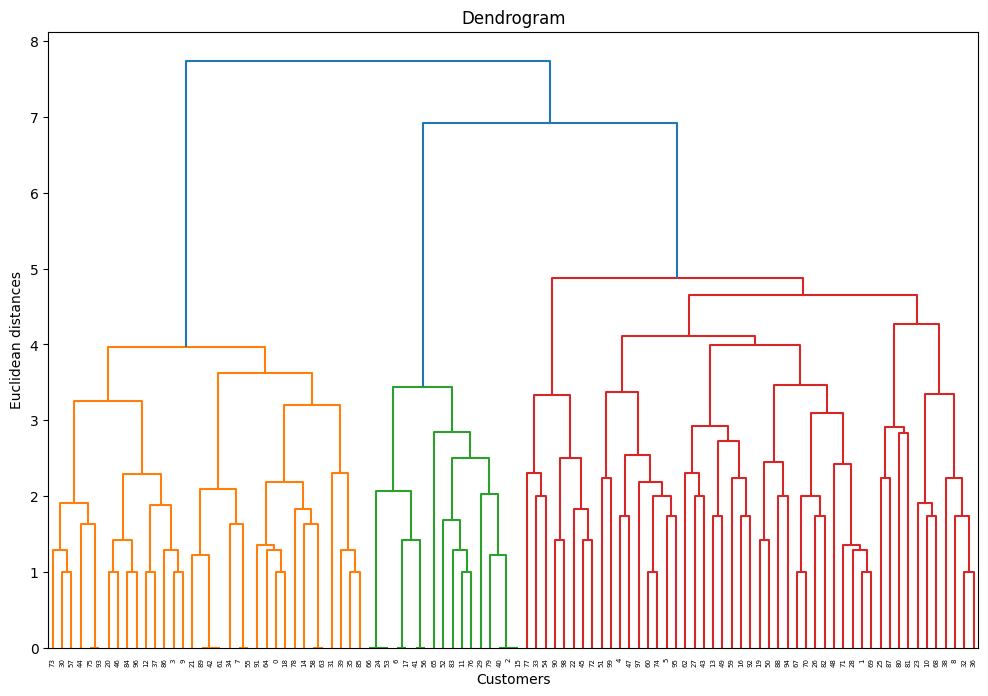

In [93]:
# What if we use a hierarchical clustering technique, like Agglomerative Clustering with cosine distance
# measurements, instead of Kmeans which uses Euclidean distance?
# We start by producing a Dendrogram chart instead of a Skree plot to find the optimal cluster number.
# This dendrogram suggests that we should start with just 3 clusters.

plt.figure(figsize=(12,8))

dendrogram = sch.dendrogram(sch.linkage(df_pivot_tp, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.show()

In [94]:
# With the Kmeans algo, we got more than three good observations so going for only three
# clusters doesn't seem like enough. Let's star with four clusters and see what we get.

aggclusters = 4

model = AgglomerativeClustering(n_clusters=aggclusters, linkage="average", affinity="cosine")
model.fit(df_pivot_tp)

/Users/gloriahwoang/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=4)

In [95]:
# Like above, map cluster numbers to customers, then to transactions, then sum the transactions
# by cluster and match up to offer attributes for sorting.

df_agglom_map = pd.DataFrame()
df_agglom_map['Customer Last Name'] = df_pivot_tp.index.values
df_agglom_map['cluster'] = model.labels_

df_agglom_map = df_agglom_map.merge(df_pivot_tp, on = 'Customer Last Name', how = 'right')
df_agglom_map = df_agglom_map.iloc[:,1:34]

df_agglom_counts = df_agglom_map.groupby('cluster').sum()

df_agglom_counts_tp = df_agglom_counts.transpose()
df_agglom_counts_tp.index.name = "Offer #"

df_offer_aggloms = offers.merge(df_agglom_counts_tp, on='Offer #', how='right')
df_offer_aggloms = df_offer_aggloms[['Offer #'] + [ col for col in df_offer_aggloms.columns if col != 'Offer #' ]]
df_offer_aggloms

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3
0,1,January,Malbec,72,56,France,False,6.0,4.0,0.0,0.0
1,2,January,Pinot Noir,72,17,France,False,5.0,0.0,0.0,5.0
2,3,February,Espumante,144,32,Oregon,True,5.0,0.0,1.0,0.0
3,4,February,Champagne,72,48,France,True,9.0,3.0,0.0,0.0
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True,0.0,4.0,0.0,0.0
5,6,March,Prosecco,144,86,Chile,False,8.0,3.0,1.0,0.0
6,7,March,Prosecco,6,40,Australia,True,4.0,0.0,15.0,0.0
7,8,March,Espumante,6,45,South Africa,False,4.0,0.0,16.0,0.0
8,9,April,Chardonnay,144,57,Chile,False,3.0,7.0,0.0,0.0
9,10,April,Prosecco,72,52,California,False,3.0,2.0,2.0,0.0


In [98]:
# Sort by cluster 0. Observe that these folks love white and sparkling wine.

df_offer_agglom0 = df_offer_aggloms.sort_values(by=0, ascending=False)
df_offer_agglom0.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3
21,22,August,Champagne,72,63,France,False,18.0,3.0,0.0,0.0
30,31,December,Champagne,72,89,France,False,15.0,2.0,0.0,0.0
10,11,May,Champagne,72,85,France,False,10.0,3.0,0.0,0.0
3,4,February,Champagne,72,48,France,True,9.0,3.0,0.0,0.0
5,6,March,Prosecco,144,86,Chile,False,8.0,3.0,1.0,0.0
0,1,January,Malbec,72,56,France,False,6.0,4.0,0.0,0.0
29,30,December,Malbec,6,54,France,False,6.0,0.0,16.0,0.0
27,28,November,Cabernet Sauvignon,12,56,France,True,6.0,0.0,0.0,0.0
26,27,October,Champagne,72,88,New Zealand,False,6.0,2.0,1.0,0.0
1,2,January,Pinot Noir,72,17,France,False,5.0,0.0,0.0,5.0


In [100]:
# Sort by cluster 1. This group like classic wine - classic white, classic red

df_offer_agglom1 = df_offer_aggloms.sort_values(by=1, ascending=False)
df_offer_agglom1.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3
13,14,June,Merlot,72,64,Chile,False,1.0,8.0,0.0,0.0
8,9,April,Chardonnay,144,57,Chile,False,3.0,7.0,0.0,0.0
0,1,January,Malbec,72,56,France,False,6.0,4.0,0.0,0.0
14,15,June,Cabernet Sauvignon,144,19,Italy,False,2.0,4.0,0.0,0.0
22,23,September,Chardonnay,144,39,South Africa,False,1.0,4.0,0.0,0.0
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True,0.0,4.0,0.0,0.0
5,6,March,Prosecco,144,86,Chile,False,8.0,3.0,1.0,0.0
21,22,August,Champagne,72,63,France,False,18.0,3.0,0.0,0.0
3,4,February,Champagne,72,48,France,True,9.0,3.0,0.0,0.0
25,26,October,Pinot Noir,144,83,Australia,False,1.0,3.0,0.0,11.0


In [102]:
# Sort by cluster 2. Observe that this group does not like to buy in high quantity.

df_offer_agglom2 = df_offer_aggloms.sort_values(by=2, ascending=False)
df_offer_agglom2.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3
29,30,December,Malbec,6,54,France,False,6.0,0.0,16.0,0.0
7,8,March,Espumante,6,45,South Africa,False,4.0,0.0,16.0,0.0
6,7,March,Prosecco,6,40,Australia,True,4.0,0.0,15.0,0.0
28,29,November,Pinot Grigio,6,87,France,False,2.0,0.0,15.0,0.0
17,18,July,Espumante,6,50,Oregon,False,1.0,0.0,13.0,0.0
12,13,May,Merlot,6,43,Chile,False,0.0,0.0,6.0,0.0
9,10,April,Prosecco,72,52,California,False,3.0,2.0,2.0,0.0
2,3,February,Espumante,144,32,Oregon,True,5.0,0.0,1.0,0.0
5,6,March,Prosecco,144,86,Chile,False,8.0,3.0,1.0,0.0
20,21,August,Champagne,12,50,California,False,3.0,0.0,1.0,0.0


In [103]:
# Sort by cluster 3. Observe that we have some big time Pinot Noir fans here.

df_offer_agglom3 = df_offer_aggloms.sort_values(by=3, ascending=False)
df_offer_agglom3.head(10)

,Offer #,Campaign,Varietal,Minimum Qty (ltr),Discount (%),Origin,Past Peak,0,1,2,3
23,24,September,Pinot Noir,6,34,Italy,False,0.0,0.0,0.0,12.0
25,26,October,Pinot Noir,144,83,Australia,False,1.0,3.0,0.0,11.0
16,17,July,Pinot Noir,12,47,Germany,False,0.0,0.0,0.0,7.0
1,2,January,Pinot Noir,72,17,France,False,5.0,0.0,0.0,5.0
11,12,May,Prosecco,72,83,Australia,False,3.0,0.0,1.0,1.0
15,16,June,Merlot,72,88,California,False,3.0,1.0,0.0,1.0
28,29,November,Pinot Grigio,6,87,France,False,2.0,0.0,15.0,0.0
27,28,November,Cabernet Sauvignon,12,56,France,True,6.0,0.0,0.0,0.0
26,27,October,Champagne,72,88,New Zealand,False,6.0,2.0,1.0,0.0
29,30,December,Malbec,6,54,France,False,6.0,0.0,16.0,0.0
